In [2]:
import pandas as pd
import numpy as np
import re

from torch import nn
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import *
import torchvision.models as models


import torch.nn as nn
from transformers import BertModel, BertTokenizer
import torch.nn as nn
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer, util
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from torch.nn import Transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


# import pre-processed data
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import keras_toolkit as kt
import keras.backend as K
from sklearn.model_selection import train_test_split
from textwrap import wrap


/home/vscode/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-16 04:21:25.294443: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 04:21:26.172819: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from text_process import process_text
training_dataset = pd.read_csv('/workspaces/Shopee-Price-Match-Guarantee/15_after_processed/train.csv')
val_dataset = pd.read_csv('/workspaces/Shopee-Price-Match-Guarantee/15_after_processed/val.csv')
testing_dataset = pd.read_csv('/workspaces/Shopee-Price-Match-Guarantee/15_after_processed/test.csv')
training_dataset, val_dataset, testing_dataset = process_text(training_dataset, val_dataset, testing_dataset)
training_dataset.head()

,posting_id,image,image_phash,title,label_group,proc_title
0,train_2249428809,40d304f91be807fed3b796a158a034f7.jpg,bc69d33e86b491c1,AMTECH Klem C Set 3 Pcs - Catok Clamp 1 2 3 Inch,3685949317,amtech klem c set pcs catok clamp inch
1,train_1453612941,e05aa71652e2546dbc2a6a2d18cc4aa7.jpg,bcfcc1a80ee930da,Cetakan Kue Pukis 10 Lubang Pancong Teflon Ran...,2236232282,cetakan kue pukis lubang pancong teflon rangin...
2,train_414717665,0c0f97f726132be83c7b84e0ca9e604e.jpg,bc4aa5a5de34d2e0,(COD)TAS TOTE BAG T76 TAS CANVAS FASHION WANIT...,3145779110,codtas tote bag t tas canvas fashion wanita im...
3,train_404098311,fedf1394058d6e439698356c0be6f4d6.jpg,cbceb1a14e8bf046,(1kg=7pcs) MEIRA CARDIGAN CARDI OUTHER TANPA J...,4171236554,kgpcs meira cardigan cardi outher tanpa jilbab
4,train_653040440,cfb08184ebbef7a5409e1bd1a0f6d0d9.jpg,c44eec61e516d2b9,Wardah Lightening Day Cream 30gr or night cre...,1774190279,wardah lightening day cream gr night cream gr


In [4]:
dist_model = SentenceTransformer('stsb-distilbert-base')
dist_model.max_seq_length = 128

train_titles = training_dataset.proc_title.tolist()
train_embed = dist_model.encode(train_titles, show_progress_bar=True, convert_to_tensor=True)

val_titles = val_dataset.proc_title.tolist()
val_embed = dist_model.encode(val_titles, show_progress_bar=True, convert_to_tensor=True)

Batches: 100%|██████████| 172/172 [00:01<00:00, 111.51it/s]


In [5]:
IMG_SIZE = 224
size = (IMG_SIZE,IMG_SIZE)
img_model = tf.keras.applications.ResNet50(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False, weights = 'imagenet' )

2023-04-16 04:21:39.097334: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


94765736/94765736 [==============================] - 0s 0us/step


In [6]:
def get_textEmbeddings(model,text):
    text_embedding = model.encode(text, convert_to_tensor=True)
    return text_embedding

def get_imageEmbeddings(model,imagePath):
    image = tf.keras.preprocessing.image.load_img(imagePath,target_size= size)
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    img_embeddings = model(input_arr)
    meanImgEmb1 = np.mean(img_embeddings,axis =0)
    meanImgEmb2 = np.mean(meanImgEmb1,axis=0)
    meanImgEmb = np.mean(meanImgEmb2,axis=0)
    return meanImgEmb

X_train, X_val, y_train, y_val = train_embed, val_embed, training_dataset.label_group, val_dataset.label_group

In [7]:
text_embeddings={}
image_embeddings={}
for index,row in  training_dataset.iterrows():
    txt_emb = get_textEmbeddings(dist_model,str(row['proc_title']))
    imagePath = '/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/train_images/'+row[1]
    img_emb = get_imageEmbeddings(img_model,imagePath)
    text_embeddings[row[0]] = txt_emb
    image_embeddings[row[0]] = img_emb

In [ ]:
val_text_embeddings={}
val_image_embeddings={}
for index,row in  val_dataset.iterrows():
    txt_emb = get_textEmbeddings(dist_model,str(row['proc_title']))
    imagePath = '/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/train_images/'+row[1]
    img_emb = get_imageEmbeddings(img_model,imagePath)
    val_text_embeddings[row[0]] = txt_emb
    val_image_embeddings[row[0]] = img_emb

test_text_embeddings={}
test_image_embeddings={}
for index,row in  testing_dataset.iterrows():
    txt_emb = get_textEmbeddings(dist_model,str(row['proc_title']))
    imagePath = '/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/train_images/'+row[1]
    img_emb = get_imageEmbeddings(img_model,imagePath)
    test_text_embeddings[row[0]] = txt_emb
    test_image_embeddings[row[0]] = img_emb

In [ ]:
keyList=[]
cembList=[]
imageList=[]
titleList=[]
for index, row in training_dataset.iterrows():
    txt_emb = text_embeddings[row[0]].cpu().numpy()
    img_emb = image_embeddings[row[0]]
    cmb_emb = np.concatenate((txt_emb,img_emb),axis=0)

    norm = np.linalg.norm(cmb_emb)
    cmb_emb_normal = cmb_emb/norm
    
    keyList.append(row[0])
    cembList.append(cmb_emb_normal)
    imageList.append(row['image'])
    titleList.append(row['proc_title'])

In [ ]:
keyList=[]
val_cembList=[]
imageList=[]
titleList=[]
for index, row in val_dataset.iterrows():
    txt_emb = val_text_embeddings[row[0]].cpu().numpy()
    img_emb = val_image_embeddings[row[0]]
    cmb_emb = np.concatenate((txt_emb,img_emb),axis=0)

    norm = np.linalg.norm(cmb_emb)
    cmb_emb_normal = cmb_emb/norm
    
    keyList.append(row[0])
    val_cembList.append(cmb_emb_normal)
    imageList.append(row['image'])
    titleList.append(row['proc_title'])

In [ ]:
acc_dict = {}
f1_dict = {}
X_train, X_val, y_train, y_val = cembList, val_cembList, training_dataset.label_group, val_dataset.label_group


from sklearn.metrics import accuracy_score, f1_score
for k in [1, 2, 3, 5, 10, 25, 50, 100]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)

    # Evaluate the performance on the test set
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')
    acc_dict[k] = accuracy
    f1_dict[k] = f1


Text(0, 0.5, 'Score')

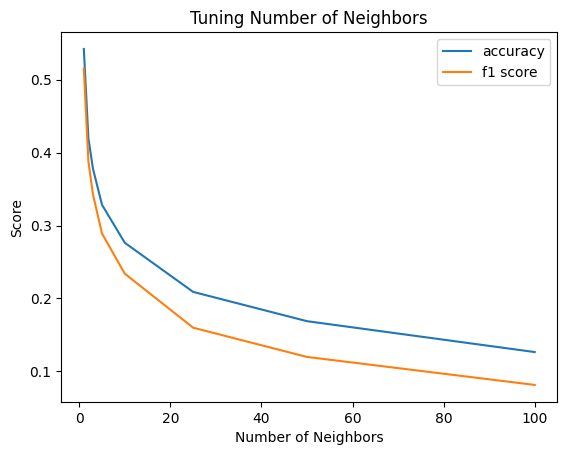

In [ ]:
plt.plot(acc_dict.keys(), acc_dict.values(), label='accuracy')
plt.plot(f1_dict.keys(), f1_dict.values(), label='f1 score')
plt.legend()
plt.title('Tuning Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Score')

In [1]:
keyList=[]
test_cembList=[]
test_imageList=[]
test_titleList=[]
for index, row in testing_dataset.iterrows():
    txt_emb = test_text_embeddings[row[0]].cpu().numpy()
    img_emb = test_image_embeddings[row[0]]
    cmb_emb = np.concatenate((txt_emb,img_emb),axis=0)

    norm = np.linalg.norm(cmb_emb)
    cmb_emb_normal = cmb_emb/norm
    
    keyList.append(row[0])
    test_cembList.append(cmb_emb_normal)
    test_imageList.append(row['image'])
    test_titleList.append(row['proc_title'])

NameError: name 'testing_dataset' is not defined

Bad pipe message: %s [b'\xfb?\xeb\xb3\x04\x8f\xc2\x8ah\x8b\x8c{k\x84<U\xa9\x0e 7\xde\x8e2\x80^\xea\xee\xc0cl\x15\xc0R\x01F\x89\xca9\x1b\xa5\xa5n\xfc\xf7']
Bad pipe message: %s [b'\xdd\xe8\x07K\x1a\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 \x18\xdb\x89\xb4\xf6t\xc7\x9eS\xfe\x9b']
Bad pipe message: %s [b"\xc7\x17\xd4\xbc\xe3\x9f)\x1dxhQ\xc3[\xff?\x1f\xbb\x8d\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\

In [ ]:
X_test, y_test = test_cembList, testing_dataset.label_group

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Accuracy = {accuracy}')
print(f'F1 score = {f1}')

Accuracy = 0.40817518248175183
F1 score = 0.37408679172637144
